<a href="https://colab.research.google.com/github/justaguyalways/Hand-gesture-detector/blob/main/Hand_Gestures_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline
np.random.seed(1)

In [ ]:
#cnn_utils

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops


def load_happy_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def load_signs_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

  
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k *
                                  mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches *
                                  mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches *
                                  mini_batch_size: m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y


def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # Numpy Equivalents:
    # Z1 = np.dot(W1, X) + b1
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    # Z2 = np.dot(W2, a1) + b2
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    # Z3 = np.dot(W3,Z2) + b3
    Z3 = tf.add(tf.matmul(W3, A2), b3)

    return Z3


def predict(X, parameters):

    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.placeholder("float", [12288, 1])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction

# def predict(X, parameters):
#
#    W1 = tf.convert_to_tensor(parameters["W1"])
#    b1 = tf.convert_to_tensor(parameters["b1"])
#    W2 = tf.convert_to_tensor(parameters["W2"])
#    b2 = tf.convert_to_tensor(parameters["b2"])
##    W3 = tf.convert_to_tensor(parameters["W3"])
##    b3 = tf.convert_to_tensor(parameters["b3"])
#
# params = {"W1": W1,
# "b1": b1,
# "W2": W2,
# "b2": b2,
# "W3": W3,
# "b3": b3}
#
#    params = {"W1": W1,
#              "b1": b1,
#              "W2": W2,
#              "b2": b2}
#
#    x = tf.placeholder("float", [12288, 1])
#
#    z3 = forward_propagation(x, params)
#    p = tf.argmax(z3)
#
#    with tf.Session() as sess:
#        prediction = sess.run(p, feed_dict = {x: X})
#
#    return prediction

In [ ]:
#test_utils

import numpy as np
from termcolor import colored

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dense


# Compare the two inputs
def comparator(learner, instructor):
    for a, b in zip(learner, instructor):
        if tuple(a) != tuple(b):
            print(colored("Test failed", attrs=['bold']),
                  "\n Expected value \n\n", colored(f"{b}", "green"), 
                  "\n\n does not match the input value: \n\n", 
                  colored(f"{a}", "red"))
            raise AssertionError("Error in test") 
    print(colored("All tests passed!", "green"))

# extracts the description of a given model
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

def datatype_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += datatype_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} in variable {}. Got {} but expected type {}".format(error,
                                                                          key, type(target_output[key]), type(expected_output[key])))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += datatype_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} in variable {}, expected type: {}  but expected type {}".format(error,
                                                                          i, type(target_output[i]), type(expected_output[i])))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        assert isinstance(target_output, type(expected_output))
        return 1
            
def equation_output_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += equation_output_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error,
                                                                          key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += equation_output_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable in position {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(target_output, 'shape'):
            np.testing.assert_array_almost_equal(target_output, expected_output)
        else:
            assert target_output == expected_output
        return 1
    
def shape_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += shape_check(expected_output[key], 
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try: 
                success += shape_check(expected_output[i], 
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0
                
    else:
        if hasattr(target_output, 'shape'):
            assert target_output.shape == expected_output.shape
        return 1
                
def single_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            if test_case['name'] == "datatype_check":
                assert isinstance(target(*test_case['input']),
                                  type(test_case["expected"]))
                success += 1
            if test_case['name'] == "equation_output_check":
                assert np.allclose(test_case["expected"],
                                   target(*test_case['input']))
                success += 1
            if test_case['name'] == "shape_check":
                assert test_case['expected'].shape == target(*test_case['input']).shape
                success += 1
        except:
            print("Error: " + test_case['error'])
            
    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))
        
def multiple_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            target_answer = target(*test_case['input'])                   
            if test_case['name'] == "datatype_check":
                success += datatype_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "equation_output_check":
                success += equation_output_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "shape_check":
                success += shape_check(test_case['expected'], target_answer, test_case['error'])
        except:
            print("Error: " + test_case['error'])
            
    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))
        

In [ ]:
  train = h5py.File('datasets/train_signs.h5', "r")
  test = h5py.File('datasets/test_signs.h5', "r")

In [ ]:
x_train_orig = np.array(train['train_set_x'][:])
y_train_orig = np.array(train['train_set_y'][:])
classes = np.array(train['list_classes'][:])
x_test_orig = np.array(test['test_set_x'][:])
y_test_orig = np.array(test['test_set_y'][:])

y = 4


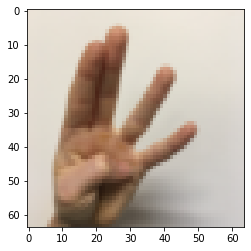

In [ ]:
index = 9
plt.imshow(x_train_orig[index])
print ("y = " + str(np.squeeze(y_train_orig[index])))

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
x_train = x_train_orig/255.
x_test = x_test_orig/255.
y_train = convert_to_one_hot(y_train_orig, 6).T
y_test = convert_to_one_hot(y_test_orig, 6).T

In [ ]:
#in the model step(last step) no need to specify input outputs

def cnn_model(input_shape): 
  input_img = tf.keras.Input(shape = (input_shape) )
  z1 = tfl.Conv2D(filters = 8 , kernel_size = 4 , padding = 'same')(input_img) 
  a1 = tfl.ReLU()(z1) 
  p1 = tfl.MaxPool2D(pool_size = 8 , strides = 8 , padding = 'same')(a1)
  z2 = tfl.Conv2D(filters= 16. , kernel_size=2 , padding='same',strides=1)(p1) 
  a2 =  tfl.ReLU()(z2) 
  p2 = tfl.MaxPool2D(pool_size=4, strides=4, padding='SAME')(a2) 
  f = tfl.Flatten()(p2) 
  outputs = tfl.Dense(units = 6 , activation = 'softmax')(f) 
  model = tf.keras.Model(input_img , outputs) 
  return model

In [ ]:
cnnmodel = cnn_model((64, 64, 3))
cnnmodel.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnnmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         392       
                                                                 
 re_lu_2 (ReLU)              (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          528       
                                                                 
 re_lu_3 (ReLU)              (None, 8, 8, 16)          0         
                                                           

In [ ]:
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]
    
comparator(summary(cnnmodel), output)

All tests passed!


In [ ]:
# normal numpy datasets cannnot be used instead of tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)
history1 = cnnmodel.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 3s 113ms/step - loss: 1.8357 - accuracy: 0.1667 - val_loss: 1.7968 - val_accuracy: 0.1667
Epoch 2/100
17/17 [==============================] - 2s 102ms/step - loss: 1.7933 - accuracy: 0.1667 - val_loss: 1.7897 - val_accuracy: 0.1667
Epoch 3/100
17/17 [==============================] - 2s 103ms/step - loss: 1.7897 - accuracy: 0.1824 - val_loss: 1.7865 - val_accuracy: 0.2083
Epoch 4/100
17/17 [==============================] - 2s 103ms/step - loss: 1.7872 - accuracy: 0.1843 - val_loss: 1.7849 - val_accuracy: 0.2167
Epoch 5/100
17/17 [==============================] - 2s 141ms/step - loss: 1.7844 - accuracy: 0.2074 - val_loss: 1.7824 - val_accuracy: 0.2000
Epoch 6/100
17/17 [==============================] - 3s 165ms/step - loss: 1.7800 - accuracy: 0.2898 - val_loss: 1.7766 - val_accuracy: 0.2667
Epoch 7/100
17/17 [==============================] - 3s 153ms/step - loss: 1.7684 - accuracy: 0.2611 - val_loss: 1.7685 - val_accuracy: 0.2417

In [ ]:
history1.history #.history can be used to find the cost values on that object

{'loss': [1.8357360363006592,
  1.7933480739593506,
  1.789654016494751,
  1.7872434854507446,
  1.7844117879867554,
  1.7800017595291138,
  1.768409013748169,
  1.7531838417053223,
  1.7329421043395996,
  1.7094396352767944,
  1.6826074123382568,
  1.6506052017211914,
  1.6160434484481812,
  1.5781874656677246,
  1.5386885404586792,
  1.4976227283477783,
  1.4563515186309814,
  1.416031002998352,
  1.3735682964324951,
  1.335135579109192,
  1.2970510721206665,
  1.2597378492355347,
  1.2237112522125244,
  1.1889491081237793,
  1.15513277053833,
  1.1212067604064941,
  1.088361144065857,
  1.057988166809082,
  1.0277066230773926,
  0.9997084736824036,
  0.9732856750488281,
  0.9474768042564392,
  0.9236140847206116,
  0.9012059569358826,
  0.8798903822898865,
  0.8587380051612854,
  0.8402412533760071,
  0.8219667673110962,
  0.8052193522453308,
  0.7884497046470642,
  0.773297905921936,
  0.7584643363952637,
  0.7442700266838074,
  0.731492280960083,
  0.7181780338287354,
  0.70618820

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

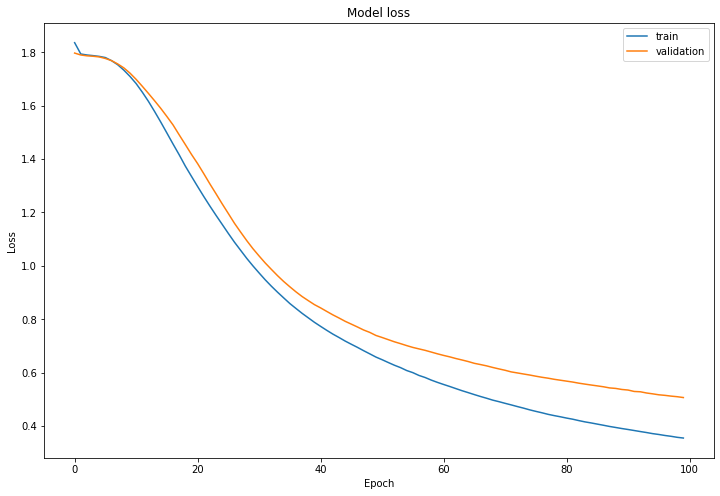

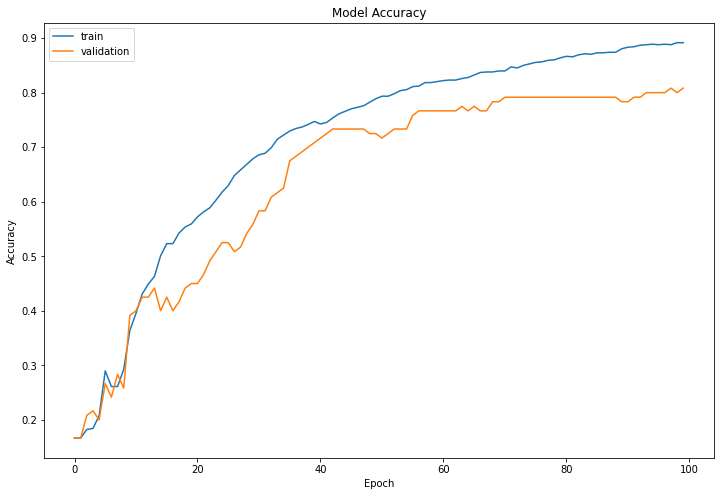

In [ ]:
df_loss_acc = pd.DataFrame(history1.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')


In [ ]:
results = cnnmodel.evaluate(x_test, y_test, batch_size=128)

2/2 [==============================] - 0s 48ms/step - loss: 0.5066 - accuracy: 0.8083


In [ ]:
img_path = 'images/my_image.jpg'
#load image actuall resizes the image to required size without loss of data
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)
#converts to numpy array
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#preprocesses input for required distribution as per model
x = preprocess_input(x)
#.predict is used to predict
print(cnnmodel.predict(x))

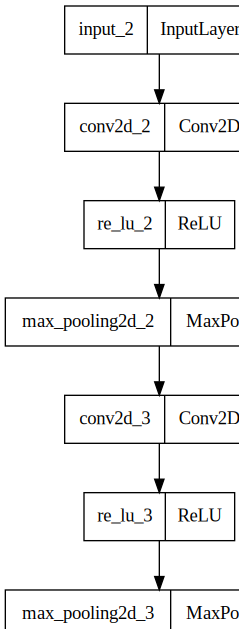

In [ ]:
plot_model(cnnmodel, to_file='HappyModel.png')
#better format(social media) else first line is enough
SVG(model_to_dot(cnnmodel).create(prog='dot', format='svg'))

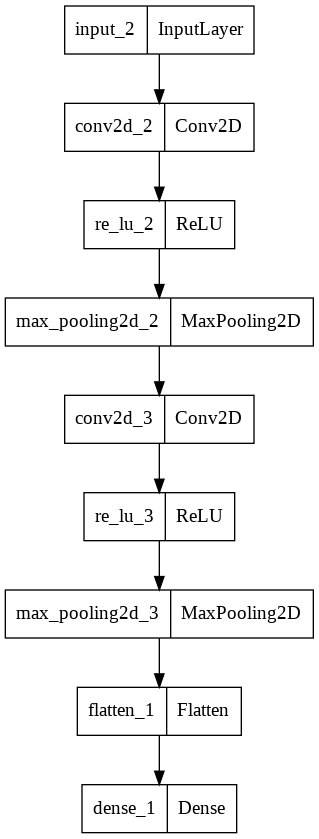

In [ ]:
plot_model(cnnmodel)